In [ ]:
!pip install tensorflow
!pip  install keras

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os

# Import libraries for image processing
from skimage import io
from skimage.filters import gaussian

# Step 1: Create a Pretext Model (Rotation Prediction)
input_shape = (224, 224, 3)

input_layer = Input(shape=input_shape)

# Define your model architecture for the rotation prediction task 5 layers CNN
x = Conv2D(128, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(8, activation='relu')(x)
rotation_output = Dense(4, activation='softmax', name='rotation')(x)

pretext_model = Model(inputs=input_layer, outputs=rotation_output)

# Step 2: Data Augmentation (Including Rotations)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=4,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1.0 / 255,
)

# Step 3: Load and Preprocess Data
unlabeled_data_dir = "/kaggle/input/unlabeled/Unlabeled images"

# List all image files in the directory
image_files = [os.path.join(unlabeled_data_dir, filename) for filename in os.listdir(unlabeled_data_dir) if filename.endswith(('.jpg', '.jpeg', '.png'))]

# Shuffle the list of image files
np.random.shuffle(image_files)

# Step 4: Train the Pretext Model
pretext_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy')

# Define the batch size
batch_size = 32  # You can adjust this value as needed

# Generate random labels for the rotation prediction task (since data is unlabeled)
num_samples = len(image_files)
random_labels = np.random.randint(0, 4, size=num_samples)

# Convert random_labels to one-hot encoding
random_labels_onehot = tf.keras.utils.to_categorical(random_labels, num_classes=11)

# Create a custom training loop
for epoch in range(10):  # Adjust the number of epochs as needed
    for i in range(0, num_samples, batch_size):

        batch_files = image_files[i:i + batch_size]
        batch_images = [img_to_array(load_img(file, target_size=(224, 224))) for file in batch_files]

        # Apply a noise reduction filter (e.g., Gaussian filter) to each image
        batch_images = [gaussian(image, sigma=0.2, channel_axis=-1) for image in batch_images]

        batch_images = np.array(batch_images)
        batch_labels = random_labels_onehot[i:i + batch_size]

        pretext_model.train_on_batch(batch_images, batch_labels)

# Step 5: Save the Pretext Model
pretext_model.save('self_supervised_model2.h5')
# Print the summary of the Pretext Model
pretext_model.summary()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Dropout
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Load the pretrained self-supervised model
pretext_model = tf.keras.models.load_model('self_supervised_model2.h5')

num_classes = 11

# Define a new model for the downstream task with 12 CNN layers
downstream_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dense(256, activation='relu'),

    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dense(38, activation='relu'),#40

    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the downstream model
downstream_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

downstream_model.summary()

# Define data generators for your labeled dataset
train_data_dir = '/kaggle/input/changed/Changed/train'
test_data_dir = '/kaggle/input/changed/Changed/test'
batch_size = 32

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Fine-tune the downstream model on the labeled data
downstream_model.fit(train_generator, epochs=20)  # You can adjust the number of epochs

# Evaluate the model on a test dataset
test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for consistent evaluation
)

eval_result = downstream_model.evaluate(test_generator)

print(f'Test loss: {eval_result[0]}')
print(f'Test accuracy: {eval_result[1]}')

# Generate predictions
y_true = test_generator.classes
y_pred = downstream_model.predict(test_generator)
y_pred = y_pred.argmax(axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices))

# Plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = range(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, str(cm[i, j]), horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

class_names = list(test_generator.class_indices.keys())
plot_confusion_matrix(cm, class_names)
downstream_model.save_weights('downstream_model_weights2.h5')



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

# Generate predictions
y_true_categorical = to_categorical(y_true, num_classes=num_classes)
y_pred = downstream_model.predict(test_generator)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_categorical[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_categorical.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot micro-average ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})', color='deeppink', linestyle=':', linewidth=4)

# Plot ROC curve for each class
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# For output checking
import tensorflow as tf

# Load the pretrained self-supervised model
pretext_model = tf.keras.models.load_model('self_supervised_model2.h5')

# Define a new model for the downstream task with 12 CNN layers
num_classes = 11
downstream_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dense(256, activation='relu'),

    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dense(38, activation='relu'),

    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Load the downstream model weights
downstream_model.load_weights('downstream_model_weights2.h5')


In [ ]:
# Preprocessing the image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess an image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Path to the image you want to test
image_path = '/kaggle/input/changed/Changed/validation/2S1/HB15097.jpeg'

# Preprocess the image
input_image = preprocess_image(image_path)


In [ ]:
# Get predictions from both models
pretext_predictions = pretext_model.predict(input_image)
downstream_predictions = downstream_model.predict(input_image)

# Get the class labels
pretext_class = np.argmax(pretext_predictions)
downstream_class = np.argmax(downstream_predictions)


In [ ]:
# Load and display the original image
original_image = plt.imread(image_path)
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')


In [ ]:
# Display the image with predicted labels
predicted_image = plt.imread(image_path)  # You can modify this line to overlay labels on the original image
plt.subplot(1, 2, 2)
plt.imshow(predicted_image)
plt.title(f'Pretext Prediction: {pretext_class}, Downstream Prediction: {downstream_class}')

plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os

# Import libraries for image processing
from skimage import io
from skimage.filters import gaussian

# Step 1: Create a Pretext Model (Rotation Prediction)
input_shape = (224, 224, 3)

input_layer = Input(shape=input_shape)

# Define your model architecture for the rotation prediction task 5 layers CNN
x = Conv2D(128, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(8, activation='relu')(x)
rotation_output = Dense(4, activation='softmax', name='rotation')(x)

pretext_model = Model(inputs=input_layer, outputs=rotation_output)

# Step 2: Data Augmentation (Including Rotations)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=4,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1.0 / 255,
)

# Step 3: Load and Preprocess Data
unlabeled_data_dir = "/kaggle/input/unlabeled/Unlabeled images"

# List all image files in the directory
image_files = [os.path.join(unlabeled_data_dir, filename) for filename in os.listdir(unlabeled_data_dir) if filename.endswith(('.jpg', '.jpeg', '.png'))]

# Shuffle the list of image files
np.random.shuffle(image_files)

# Step 4: Train the Pretext Model
pretext_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy')

# Define the batch size
batch_size = 32  # You can adjust this value as needed

# Generate random labels for the rotation prediction task (since data is unlabeled)
num_samples = len(image_files)
random_labels = np.random.randint(0, 4, size=num_samples)

# Convert random_labels to one-hot encoding
random_labels_onehot = tf.keras.utils.to_categorical(random_labels, num_classes=11)

# Create a custom training loop
for epoch in range(10):  # Adjust the number of epochs as needed
    for i in range(0, num_samples, batch_size):

        batch_files = image_files[i:i + batch_size]
        batch_images = [img_to_array(load_img(file, target_size=(224, 224))) for file in batch_files]

        # Apply a noise reduction filter (e.g., Gaussian filter) to each image
        batch_images = [gaussian(image, sigma=0.2, channel_axis=-1) for image in batch_images]

        batch_images = np.array(batch_images)
        batch_labels = random_labels_onehot[i:i + batch_size]

        pretext_model.train_on_batch(batch_images, batch_labels)

# Step 5: Save the Pretext Model
pretext_model.save('self_supervised_model2.h5')
# Print the summary of the Pretext Model
pretext_model.summary()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Load the pretrained self-supervised model
pretext_model = tf.keras.models.load_model('self_supervised_model2.h5')

num_classes = 11

# Define a new model for the downstream task with 12 CNN layers
downstream_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the downstream model
downstream_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

downstream_model.summary()

# Define data generators with data augmentation for the labeled dataset
train_data_dir = r'/kaggle/input/changed/Changed/train'
test_data_dir = r'/kaggle/input/changed/Changed/test'
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Fine-tune the downstream model on the labeled data
downstream_model.fit(train_generator, epochs=50)  # You can adjust the number of epochs

# Evaluate the model on a test dataset
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for consistent evaluation
)

eval_result = downstream_model.evaluate(test_generator)

print(f'Test loss: {eval_result[0]}')
print(f'Test accuracy: {eval_result[1]}')

# Generate predictions
y_true = test_generator.classes
y_pred = downstream_model.predict(test_generator)
y_pred = y_pred.argmax(axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices))

# Plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = range(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, str(cm[i, j]), horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

class_names = list(test_generator.class_indices.keys())
plot_confusion_matrix(cm, class_names)
downstream_model.save_weights('downstream_model_weights2.h5')


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os

# Step 1: Create a Pretext Model (Rotation Prediction)
input_shape = (224, 224, 3)

input_layer = Input(shape=input_shape)

# Define your model architecture for the rotation prediction task 5 layers CNN
x = Conv2D(128, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(8, activation='relu')(x)
rotation_output = Dense(4, activation='softmax', name='rotation')(x)

pretext_model = Model(inputs=input_layer, outputs=rotation_output)

# Step 2: Load and Preprocess Data
unlabeled_data_dir =  "/kaggle/input/unlabeled/Unlabeled images"

# List all image files in the directory
image_files = [os.path.join(unlabeled_data_dir, filename) for filename in os.listdir(unlabeled_data_dir) if filename.endswith(('.jpg', '.jpeg', '.png'))]

# Shuffle the list of image files
np.random.shuffle(image_files)

# Step 3: Train the Pretext Model
pretext_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy')

# Define the batch size
batch_size = 32  # You can adjust this value as needed

# Generate random labels for the rotation prediction task (since data is unlabeled)
num_samples = len(image_files)
random_labels = np.random.randint(0, 4, size=num_samples)

# Convert random_labels to one-hot encoding
random_labels_onehot = tf.keras.utils.to_categorical(random_labels, num_classes=11)

# Create a custom training loop
for epoch in range(10):  # Adjust the number of epochs as needed
    for i in range(0, num_samples, batch_size):

        batch_files = image_files[i:i + batch_size]
        batch_images = [img_to_array(load_img(file, target_size=(224, 224))) for file in batch_files]

        batch_images = np.array(batch_images)
        batch_labels = random_labels_onehot[i:i + batch_size]

        pretext_model.train_on_batch(batch_images, batch_labels)

# Step 4: Save the Pretext Model
pretext_model.save('self_supervised_model_without_augmentation.h5')
# Print the summary of the Pretext Model
pretext_model.summary()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Load the pretrained self-supervised model
pretext_model = tf.keras.models.load_model('self_supervised_model2.h5')

num_classes = 11

# Define a new model for the downstream task with 12 CNN layers
downstream_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the downstream model
downstream_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

downstream_model.summary()

# Define data generators with data augmentation for the labeled dataset
train_data_dir = r'/kaggle/input/changed/Changed/train'
test_data_dir = r'/kaggle/input/changed/Changed/test'
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Fine-tune the downstream model on the labeled data
downstream_model.fit(train_generator, epochs=50)  # You can adjust the number of epochs

# Evaluate the model on a test dataset
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for consistent evaluation
)

eval_result = downstream_model.evaluate(test_generator)

print(f'Test loss: {eval_result[0]}')
print(f'Test accuracy: {eval_result[1]}')

# Generate predictions
y_true = test_generator.classes
y_pred = downstream_model.predict(test_generator)
y_pred = y_pred.argmax(axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices))

# Plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = range(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, str(cm[i, j]), horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

class_names = list(test_generator.class_indices.keys())
plot_confusion_matrix(cm, class_names)
downstream_model.save_weights('downstream_model_weights2.h5')


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming the structure:
# - train
#   - class_1
#   - class_2
#   ...
# - test
#   - class_1
#   - class_2
#   ...

train_data_dir = '/kaggle/input/changed/Changed/train'
test_data_dir = '/kaggle/input/changed/Changed/test'
input_shape = (128, 128, 1)  # Adjust according to your input size
num_classes = 11  # Adjust based on the number of classes

# Define the input layer
input_layer = Input(shape=input_shape)

# Base convolutional block
conv_block = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
conv_block = MaxPooling2D((2, 2))(conv_block)

# Multi-scale feature extraction
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_block)
conv2 = Conv2D(64, (5, 5), activation='relu', padding='same')(conv_block)
conv3 = Conv2D(64, (7, 7), activation='relu', padding='same')(conv_block)

# Concatenate features from different scales
concatenated_features = Concatenate()([conv1, conv2, conv3])

# Flatten and add dense layers
flatten_layer = Flatten()(concatenated_features)
dense_layer = Dense(256, activation='relu')(flatten_layer)
output_layer = Dense(num_classes, activation='softmax')(dense_layer)

# Create the model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model (add your choice of optimizer, loss, and metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create data generators
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(input_shape[0], input_shape[1]),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(input_shape[0], input_shape[1]),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

# Train the model
model.fit(train_generator, epochs=10, validation_data=test_generator)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os

# Step 1: Create a Pretext Model (Multi-Scale Feature + Orientation Prediction)
input_shape = (224, 224, 3)

input_layer = Input(shape=input_shape)

# Define multiple convolutional branches for different scales
conv_branch_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
conv_branch_1 = MaxPooling2D((2, 2))(conv_branch_1)

conv_branch_2 = Conv2D(64, (5, 5), activation='relu', padding='same')(input_layer)
conv_branch_2 = MaxPooling2D((2, 2))(conv_branch_2)

conv_branch_3 = Conv2D(64, (7, 7), activation='relu', padding='same')(input_layer)
conv_branch_3 = MaxPooling2D((2, 2))(conv_branch_3)

# Concatenate the outputs of different scales
concatenated_features = Concatenate()([conv_branch_1, conv_branch_2, conv_branch_3])

# Flatten and add dense layers for multi-scale features
x = Flatten()(concatenated_features)
x = Dense(8, activation='relu')(x)
multi_scale_output = Dense(4, activation='softmax', name='multi_scale')(x)

# Orientation Estimation Branch
orientation_branch = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
orientation_branch = MaxPooling2D((2, 2))(orientation_branch)
orientation_branch = Flatten()(orientation_branch)
orientation_output = Dense(4, activation='softmax', name='orientation')(orientation_branch)

# Concatenate the outputs of multi-scale and orientation branches
concatenated_outputs = Concatenate()([multi_scale_output, orientation_output])

# Final Output Layer for the pretext task
final_output = Dense(4, activation='softmax', name='pretext_final')(concatenated_outputs)

pretext_model = Model(inputs=input_layer, outputs=final_output)

# Step 2: Load and Preprocess Data
unlabeled_data_dir = "/kaggle/input/unlabeled/Unlabeled images"

# List all image files in the directory
image_files = [os.path.join(unlabeled_data_dir, filename) for filename in os.listdir(unlabeled_data_dir) if filename.endswith(('.jpg', '.jpeg', '.png'))]

# Shuffle the list of image files
np.random.shuffle(image_files)

# Step 3: Train the Pretext Model
pretext_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy')

# Define the batch size
batch_size = 32  # You can adjust this value as needed

# Generate random labels for the pretext prediction task (since data is unlabeled)
num_samples = len(image_files)
random_labels = np.random.randint(0, 4, size=num_samples)

# Convert random_labels to one-hot encoding
random_labels_onehot = tf.keras.utils.to_categorical(random_labels, num_classes=4)

# Create a custom training loop
for epoch in range(10):  # Adjust the number of epochs as needed
    for i in range(0, num_samples, batch_size):

        batch_files = image_files[i:i + batch_size]
        batch_images = [img_to_array(load_img(file, target_size=(224, 224))) for file in batch_files]

        batch_images = np.array(batch_images)
        batch_labels = random_labels_onehot[i:i + batch_size]

        pretext_model.train_on_batch(batch_images, batch_labels)

# Step 4: Save the Pretext Model
pretext_model.save('self_supervised_model_with_multi_scale_orientation.h5')
# Print the summary of the Pretext Model
pretext_model.summary()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Dropout
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Load the pretrained self-supervised model
pretext_model = tf.keras.models.load_model('self_supervised_model_with_multi_scale_orientation.h5')

num_classes = 11

# Define a new model for the downstream task with 12 CNN layers
downstream_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(1024, activation='relu'),

    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dense(256, activation='relu'),

    tf.keras.layers.Dense(256, activation='relu'),#40
    tf.keras.layers.Dense(60, activation='relu'),

    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the downstream model
downstream_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

downstream_model.summary()

# Define data generators for your labeled dataset
train_data_dir = '/kaggle/input/changed/Changed/train'
test_data_dir = '/kaggle/input/changed/Changed/test'
batch_size = 32

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Fine-tune the downstream model on the labeled data
downstream_model.fit(train_generator, epochs=20)  # You can adjust the number of epochs

# Evaluate the model on a test dataset
test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for consistent evaluation
)

eval_result = downstream_model.evaluate(test_generator)

print(f'Test loss: {eval_result[0]}')
print(f'Test accuracy: {eval_result[1]}')

# Generate predictions
y_true = test_generator.classes
y_pred = downstream_model.predict(test_generator)
y_pred = y_pred.argmax(axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices))

# Plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = range(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, str(cm[i, j]), horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

class_names = list(test_generator.class_indices.keys())
plot_confusion_matrix(cm, class_names)
downstream_model.save_weights('downstream_model_weights2.h5')



In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os

# Step 1: Create a Pretext Model (Multi-Scale Feature + Orientation Prediction)
input_shape = (224, 224, 3)

# Input layer
input_layer = Input(shape=input_shape)

# Apply Frost filter for multi-scale feature extraction
frost_filter = tf.image.sobel_edges(input_layer)
multi_scale_features = tf.sqrt(tf.square(frost_filter[:, :, :, :, 0]) + tf.square(frost_filter[:, :, :, :, 1]))

# Multi-Scale Feature Extraction Branch
conv_branch_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(multi_scale_features)
conv_branch_1 = MaxPooling2D((2, 2))(conv_branch_1)

conv_branch_2 = Conv2D(64, (5, 5), activation='relu', padding='same')(multi_scale_features)
conv_branch_2 = MaxPooling2D((2, 2))(conv_branch_2)

conv_branch_3 = Conv2D(64, (7, 7), activation='relu', padding='same')(multi_scale_features)
conv_branch_3 = MaxPooling2D((2, 2))(conv_branch_3)

# Concatenate multi-scale features
concatenated_features = Concatenate()([conv_branch_1, conv_branch_2, conv_branch_3])

# Flatten and add dense layers
x = Flatten()(concatenated_features)
x = Dense(8, activation='relu')(x)

# Output for multi-scale feature extraction
multi_scale_output = Dense(4, activation='softmax', name='multi_scale')(x)

# Orientation Estimation Branch
orientation_branch = Conv2D(64, (3, 3), activation='relu', padding='same')(concatenated_features)
orientation_branch = MaxPooling2D((2, 2))(orientation_branch)
orientation_branch = Flatten()(orientation_branch)
orientation_output = Dense(4, activation='softmax', name='orientation')(orientation_branch)

# Concatenate multi-scale and orientation outputs
concatenated_outputs = Concatenate()([multi_scale_output, orientation_output])

# Final Output Layer for the pretext task
final_output = Dense(4, activation='softmax', name='pretext_final')(concatenated_outputs)

# Create the Pretext Model
pretext_model = Model(inputs=input_layer, outputs=final_output)

# Display the summary of the Pretext Model
pretext_model.summary()

# Specify the path to the directory containing unlabeled images
unlabeled_data_dir = "/kaggle/input/unlabeled/Unlabeled images"

# List all image files in the directory
image_files = [os.path.join(unlabeled_data_dir, filename) for filename in os.listdir(unlabeled_data_dir) if filename.endswith(('.jpg', '.jpeg', '.png'))]

# Shuffle the list of image files
np.random.shuffle(image_files)

# Step 3: Train the Pretext Model
pretext_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy')

# Define the batch size
batch_size = 32  # You can adjust this value as needed

# Generate random labels for the pretext prediction task (since data is unlabeled)
num_samples = len(image_files)
random_labels = np.random.randint(0, 4, size=num_samples)

# Convert random_labels to one-hot encoding
random_labels_onehot = tf.keras.utils.to_categorical(random_labels, num_classes=4)

# Create a custom training loop
for epoch in range(10):  # Adjust the number of epochs as needed
    for i in range(0, num_samples, batch_size):

        batch_files = image_files[i:i + batch_size]
        batch_images = [img_to_array(load_img(file, target_size=(224, 224))) for file in batch_files]

        batch_images = np.array(batch_images)
        batch_labels = random_labels_onehot[i:i + batch_size]

        pretext_model.train_on_batch(batch_images, batch_labels)

# Step 4: Save the Pretext Model
pretext_model.save('self_supervised_model_with_multi_scale_orientation.h5')


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 tf.compat.v1.shape (TFOpLa  (4,)                         0         ['input_1[0][0]']             
 mbda)                                                                                            
                                                                                                  
 tf.__operators__.getitem (  ()                           0         ['tf.compat.v1.shape[0][0]']  
 SlicingOpLambda)                                                                                 
                                                                                              

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Found 4110 images belonging to 11 classes.
Found 439 images belonging to 11 classes.
Epoch 1/20
129/129 [==============================] - ETA: 0s - loss: 1.5697 - accuracy: 0.3949

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


129/129 [==============================] - 62s 347ms/step - loss: 1.5697 - accuracy: 0.3949 - val_loss: 0.8737 - val_accuracy: 0.6606
Epoch 2/20
129/129 [==============================] - 15s 115ms/step - loss: 0.6108 - accuracy: 0.7766 - val_loss: 0.3349 - val_accuracy: 0.8815
Epoch 3/20
129/129 [==============================] - 11s 86ms/step - loss: 0.2393 - accuracy: 0.9168 - val_loss: 0.1187 - val_accuracy: 0.9613
Epoch 4/20
129/129 [==============================] - 11s 88ms/step - loss: 0.1640 - accuracy: 0.9494 - val_loss: 0.0640 - val_accuracy: 0.9795
Epoch 5/20
129/129 [==============================] - 10s 80ms/step - loss: 0.0988 - accuracy: 0.9679 - val_loss: 0.0875 - val_accuracy: 0.9636
Epoch 6/20
129/129 [==============================] - 11s 81ms/step - loss: 0.0402 - accuracy: 0.9876 - val_loss: 0.1228 - val_accuracy: 0.9590
Epoch 7/20
129/129 [==============================] - 11s 85ms/step - loss: 0.0387 - accuracy: 0.9876 - val_loss: 0.0584 - val_accuracy: 0.9841
E

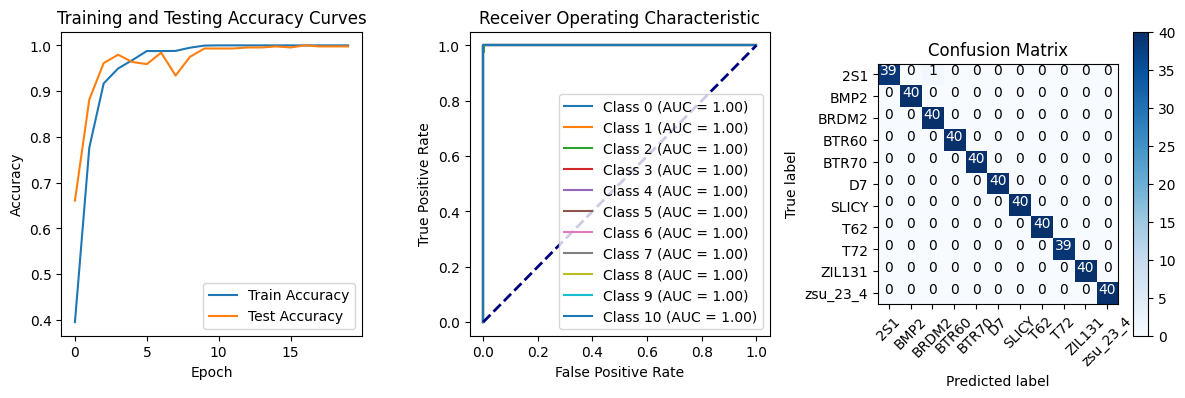

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Load the pretrained self-supervised model
pretext_model = tf.keras.models.load_model('self_supervised_model_with_multi_scale_orientation.h5')

num_classes = 11

# Define a new model for the downstream task with 12 CNN layers
downstream_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the downstream model
downstream_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define data generators for your labeled dataset
train_data_dir = '/kaggle/input/changed/Changed/train'
test_data_dir = '/kaggle/input/changed/Changed/validation'
batch_size = 32

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Set up callbacks for model training
checkpoint = ModelCheckpoint('downstream_model_weights.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the downstream model
history = downstream_model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[checkpoint, early_stopping]
)

# Plot the training and testing accuracy curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Training and Testing Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot ROC curve
plt.subplot(1, 3, 2)
y_true = test_generator.classes
y_scores = downstream_model.predict(test_generator)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Plot Confusion Matrix
plt.subplot(1, 3, 3)
y_pred = downstream_model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

plt.tight_layout()

plt.show()
